In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *

import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
model_path = os.path.join(base_path, "gaba_titration")
save_name = "test"
load_name = None
load_name = "test"

model_config = configs.sac_mode_config(ttx=False, non_ds_ach=False, offset_ampa_ach=False)
# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_gaba_titration_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        gaba_steps=[0.5, 1.],
        pool_sz=6,
    )

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
        
factors = list(d.keys())
rhos = list(d[factors[0]].keys())
idxs = list(d[factors[0]][rhos[0]].keys())

In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
factors

[0.5, 1.0]

In [7]:
metrics = {k: ana.get_sac_metrics(d[k]) for k in factors}

dir_labels = d[factors[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = ana.get_sac_thetas(d[factors[0]])
sac_deltas = ana.get_sac_deltas(sac_thetas)

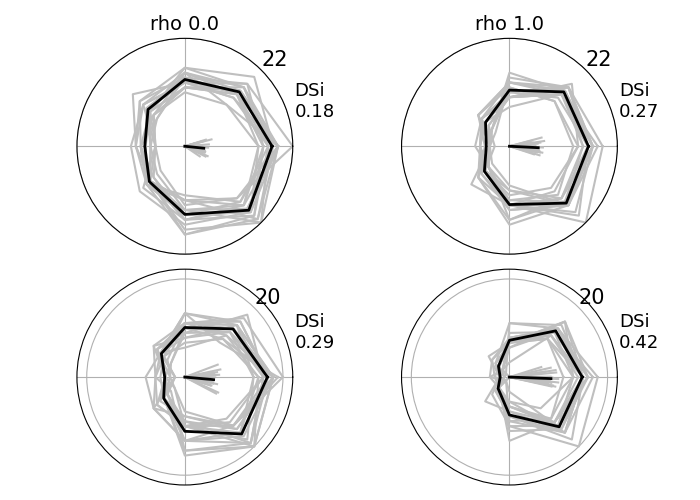

In [10]:
max_spikes = np.max([r["spikes"] for s in factors for r in metrics[s].values()])
polar_fig = plt.figure(figsize=(7, 5))
n_rows = len(factors)
n_cols = len(rhos)
polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title=None,
        title_metrics=False,
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=int("%i%i%i" % (n_rows, n_cols, (row * n_cols + col + 1))),
    )
    for row, factor in enumerate(factors)
    for col, (r, m) in enumerate(metrics[factor].items())
]
for i in range(n_cols):
    polar_ax[i].set_title("rho %.1f" % rhos[i], fontsize=14)
    
polar_fig.tight_layout()

In [9]:
close_button()